In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from preprocessed_mnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

print(X_train.shape)
print(y_train.shape)

# lables - one hot encoding

n_classes = 10

def one_hot_encoding(labels):
    n = labels.shape[0]
    one_hot = np.zeros((n, n_classes))
    one_hot[np.arange(n), labels] = 1
    return one_hot

y_train = one_hot_encoding(y_train)
y_val = one_hot_encoding(y_val)
y_test = one_hot_encoding(y_test)

print(y_train.shape)

Using TensorFlow backend.


(50000, 784)
(50000,)
(50000, 10)


In [3]:

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_classes = 10 # MNIST total classes (0-9 digits)


tf.reset_default_graph()
# input, placeholder
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# parameters
W1 = tf.Variable(tf.random_normal((n_input, n_hidden_1), stddev=0.1))
b1 = tf.Variable(tf.random_normal((n_hidden_1,), stddev=0.1))
W2 = tf.Variable(tf.random_normal((n_hidden_1, n_hidden_2), stddev=0.1))
b2 = tf.Variable(tf.random_normal((n_hidden_2,), stddev=0.1))
W3 = tf.Variable(tf.random_normal((n_hidden_2, n_classes), stddev=0.1))
b3 = tf.Variable(tf.random_normal((n_classes,), stddev=0.1))

# multi layer perceptron
Z1 = tf.matmul(X, W1) + b1
A1 = tf.nn.dropout(tf.nn.tanh(Z1), keep_prob=keep_prob)
Z2 = tf.matmul(A1, W2) + b2
A2 = tf.nn.dropout(tf.nn.tanh(Z2), keep_prob=keep_prob)
Z3 = tf.matmul(A2, W3) + b3    
A3 = tf.nn.softmax(Z3)

In [4]:
# Parameters
learning_rate = 0.0001

# Define loss and optimizer
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_function)

# Evaluate model (with test logits, for dropout to be disabled)
correct_prediction = tf.equal(tf.argmax(Z3, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# start TensorFlow session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

In [5]:
%%time

# training parameters
train_size = X_train.shape[0]
epochs = 300
batch_size = 128
dropout_keep_prob = 0.5
display_epoch = 20


# training 
train_loss_list = []
test_loss_list = []

# Start training
for epoch in range(epochs):
    perm = np.arange(train_size)
    np.random.shuffle(perm)
    for i in range(0, train_size, batch_size):
        randidx = perm[i:i+batch_size]
        batch_x = X_train[randidx, :]
        batch_y = y_train[randidx, :]
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout_keep_prob})

    if epoch % display_epoch == 0 or epoch == 1:
        train_loss, train_acc = sess.run([cost_function, accuracy], 
                                         feed_dict={X: X_train, Y: y_train, keep_prob: 1.})
        train_loss_list.append(train_loss)
        test_loss, test_acc = sess.run([cost_function, accuracy], 
                                       feed_dict={X: X_test, Y: y_test, keep_prob: 1.})
        test_loss_list.append(test_loss)

        print("Epoch " + str(epoch) + ", Training Loss = " + \
              "{:.4f}".format(train_loss) + ", Training/Test Acc = " + \
              "{:.4f}".format(train_acc) + " / " + "{:.4f}".format(test_acc))


Epoch 0, Training Loss = 0.4478, Training/Test Acc = 0.8631 / 0.8742
Epoch 1, Training Loss = 0.3599, Training/Test Acc = 0.8947 / 0.9028
Epoch 20, Training Loss = 0.1513, Training/Test Acc = 0.9557 / 0.9513
Epoch 40, Training Loss = 0.0946, Training/Test Acc = 0.9707 / 0.9633
Epoch 60, Training Loss = 0.0659, Training/Test Acc = 0.9798 / 0.9698
Epoch 80, Training Loss = 0.0486, Training/Test Acc = 0.9850 / 0.9726
Epoch 100, Training Loss = 0.0359, Training/Test Acc = 0.9886 / 0.9744
Epoch 120, Training Loss = 0.0277, Training/Test Acc = 0.9913 / 0.9766
Epoch 140, Training Loss = 0.0214, Training/Test Acc = 0.9937 / 0.9775
Epoch 160, Training Loss = 0.0167, Training/Test Acc = 0.9952 / 0.9782
Epoch 180, Training Loss = 0.0133, Training/Test Acc = 0.9962 / 0.9791
Epoch 200, Training Loss = 0.0104, Training/Test Acc = 0.9971 / 0.9790
Epoch 220, Training Loss = 0.0082, Training/Test Acc = 0.9980 / 0.9802
Epoch 240, Training Loss = 0.0067, Training/Test Acc = 0.9983 / 0.9794
Epoch 260, Tra

In [8]:
print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: X_test, Y: y_test, keep_prob: 1.}))

Testing Accuracy: 0.981


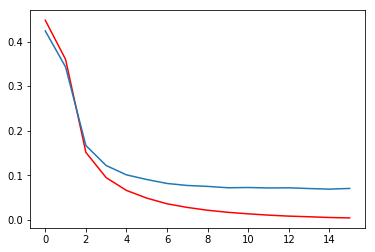

In [7]:
t = np.arange(len(train_loss_list))
plt.plot(t, train_loss_list, 'r-', t, test_loss_list, '-')
plt.show()